In [2]:
import pandas as pd
import numpy as np
import re

from tqdm import tqdm

Данные можно скачать с [kaggle](https://www.kaggle.com/datasets/wordsforthewise/lending-club?spm=a2ty_o01.29997173.0.0.532fc921UIOjfa).

Так как датасет содержит `2 260 701` наблюдений, это делает его весьма тяжелым для демонстрации функционала, снизим его до 20% наблюдений от изначального.

In [3]:
df_sample = pd.read_csv("./data/accepted_2007_to_2018Q4.csv")

# Взять 20% случайных строк (без повторений)
df = df_sample.sample(frac=0.2, random_state=42)  # random_state указываем для воспроизводимости
display(print(f"Размер датасета: {df.shape}"))
display(df.info())

C:\Users\NeKonn\AppData\Local\Temp\ipykernel_584\1521612900.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sample = pd.read_csv("./data/accepted_2007_to_2018Q4.csv")


Размер датасета: (452140, 151)


None

<class 'pandas.core.frame.DataFrame'>
Index: 452140 entries, 392949 to 867240
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 524.3+ MB


None

In [4]:
# Смотрим на то, какие признаки у нас есть в датасете
df.columns.tolist()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '

# Проведем анализ репрезентативности

**Цель анализа**

Убедиться, что случайно выбранная подвыборка (в данном случае 20% от исходных данных) адекватно отражает структуру и распределения полной выборки. Это необходимо для того, чтобы выводы, сделанные на основе подвыборки, были обобщаемыми и ненесмещёнными.

**Проверка числовых признаков**

**Что анализируется?**

Для каждого числового признака сравниваются:

- Среднее значение в полной выборке.
- Среднее значение в подвыборке.
- Относительное отклонение между ними.

| Отклонение среднего | Оценка |
|---------------------|--------|
| `< 2%` | Хорошо |
| `2–5%` | Удовлетворительно |
| `> 5%` | Тревожно |

In [6]:
# Определим данные
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Исключим сразу ненужные столбцы (ид и 
exclude_cols = ['id', 'member_id', 'issue_d']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

# Сформируем отчет по числовым признакам
report_numeric = []
for col in numeric_cols:
    full_mean = df[col].mean()
    sample_mean = df_sample[col].mean()
    
    # Избегаем деления на ноль или NaN
    if pd.isna(full_mean) or full_mean == 0:
        diff_percent = float('nan')
        status = "Не применимо"
    else:
        diff_percent = abs(full_mean - sample_mean) / abs(full_mean) * 100
        if diff_percent < 2:
            status = "Хорошо"
        elif diff_percent < 5:
            status = "Удовлетворительно"
        else:
            status = "Тревожно"

    report_numeric.append({
        'Признак': col,
        'Среднее (полная)': full_mean,
        'Среднее (подвыборка)': sample_mean,
        'Абсолютное отклонение': abs(full_mean - sample_mean),
        'Относительное отклонение (%)': diff_percent,
        'Оценка': status
    })

# Преобразуем в DataFrame
report_numeric = pd.DataFrame(report_numeric).round(4)

# Цветовая стилизация
def color_status(val):
    if val == "Хорошо":
        return "background-color: #d4edda"
    elif val == "Удовлетворительно":
        return "background-color: #fff3cd"
    elif val == "Тревожно":
        return "background-color: #f8d7da"
    return ""

print("ОТЧЁТ ПО ЧИСЛОВЫМ ПРИЗНАКАМ")
styled_numeric = report_numeric.style.applymap(color_status, subset=['Оценка'])
display(styled_numeric)

# Проведем итоговую оценку по числовым признакам
total_numeric = len(report_numeric)
good_numeric = len(report_numeric[report_numeric['Оценка'] == "Хорошо"])
warning_numeric = len(report_numeric[report_numeric['Оценка'] == "Удовлетворительно"])
bad_numeric = len(report_numeric[report_numeric['Оценка'] == "Тревожно"])

print(f"Числовые признаки: {total_numeric} всего")
print(f"Хорошо: {good_numeric}")
print(f"Удовлетворительно: {warning_numeric}")
print(f"Тревожно: {bad_numeric}")

# Новая логика на основе преобладания
if good_numeric > warning_numeric and good_numeric > bad_numeric:
    verdict_numeric = "Выборка репрезентативна: большинство числовых признаков в норме."
elif warning_numeric > good_numeric and warning_numeric > bad_numeric:
    verdict_numeric = "В целом выборка репрезентативна, но есть признаки с умеренными отклонениями."
elif bad_numeric > good_numeric and bad_numeric > warning_numeric:
    verdict_numeric = "Выборка не репрезентативна. Значительные искажения: преобладают крупные отклонения."
else:
    verdict_numeric = "Выборка неоднозначна: распределение оценок сбалансировано."

print(verdict_numeric)

ОТЧЁТ ПО ЧИСЛОВЫМ ПРИЗНАКАМ


C:\Users\NeKonn\AppData\Local\Temp\ipykernel_6564\3886954618.py:52: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_numeric = report_numeric.style.applymap(color_status, subset=['Оценка'])


,Признак,Среднее (полная),Среднее (подвыборка),Абсолютное отклонение,Относительное отклонение (%),Оценка
0,loan_amnt,15038.632800,15046.931200,8.298400,0.055200,Хорошо
1,funded_amnt,15033.657800,15041.664100,8.006300,0.053300,Хорошо
2,funded_amnt_inv,15015.775100,15023.437700,7.662600,0.051000,Хорошо
3,int_rate,13.089100,13.092800,0.003700,0.028300,Хорошо
4,installment,445.674600,445.806800,0.132200,0.029700,Хорошо
5,annual_inc,77918.871400,77992.428700,73.557300,0.094400,Хорошо
6,dti,18.846600,18.824200,0.022400,0.118800,Хорошо
7,delinq_2yrs,0.307900,0.306900,0.001000,0.320000,Хорошо
8,fico_range_low,698.603700,698.588200,0.015500,0.002200,Хорошо
9,fico_range_high,702.603900,702.588400,0.015500,0.002200,Хорошо


Числовые признаки: 112 всего
Хорошо: 108
Удовлетворительно: 2
Тревожно: 2
Выборка репрезентативна: большинство числовых признаков в норме.


**Проверка категориальных признаков**

**Что анализируется?**

Для каждого категориального признака сравниваются:

- Доли категорий в полной выборке.
- Доли категорий в подвыборке.
- Вычисляется среднее абсолютное отклонение долей по всем категориям.

| Отклонение долей | Оценка |
|------------------|--------|
| `< 1%` | Хорошо |
| `1–3%` | Удовлетворительно |
| `> 3%` | Тревожно |

In [7]:
# Сформируем отчет по категориальным признакам
report_categorical_summary = []
detailed_categorical_reports = {}  # Для детального анализа

for col in categorical_cols:
    full_dist = df[col].value_counts(normalize=True).sort_index()
    sample_dist = df_sample[col].value_counts(normalize=True).sort_index()
    
    # Совместим индексы
    all_categories = full_dist.index.union(sample_dist.index)
    full_aligned = full_dist.reindex(all_categories, fill_value=0)
    sample_aligned = sample_dist.reindex(all_categories, fill_value=0)
    
    # Разница по каждой категории
    diff_per_cat = (sample_aligned - full_aligned).abs()
    mean_abs_diff = diff_per_cat.mean() * 100  # среднее отклонение в процентах
    
    # Оценка
    if mean_abs_diff < 1:
        status = "Хорошо"
    elif mean_abs_diff < 3:
        status = "Удовлетворительно"
    else:
        status = "Тревожно"

    report_categorical_summary.append({
        'Признак': col,
        'Среднее отклонение (%)': mean_abs_diff,
        'Кол-во категорий': len(all_categories),
        'Оценка': status
    })
    
    # Сохраняем детали
    detailed = pd.DataFrame({
        'Полная выборка': full_aligned.round(4),
        'Подвыборка': sample_aligned.round(4),
        'Разница (abs)': diff_per_cat.round(4)
    })
    detailed_categorical_reports[col] = detailed

# Преобразуем в DataFrame
report_categorical_summary = pd.DataFrame(report_categorical_summary).round(4)
report_categorical_summary = report_categorical_summary.sort_values(by='Среднее отклонение (%)')

# Стилизация категориальных
styled_categorical = report_categorical_summary.style.applymap(color_status, subset=['Оценка'])

print("\n\n ОТЧЕТ ПО КАТЕГОРИАЛЬНЫМ ПРИЗНАКАМ")
display(styled_categorical)

# Проведем итоговую оценку по категориальным признакам
total_cat = len(report_categorical_summary)
good_cat = len(report_categorical_summary[report_categorical_summary['Оценка'] == "Хорошо"])
warning_cat = len(report_categorical_summary[report_categorical_summary['Оценка'] == "Удовлетворительно"])
bad_cat = len(report_categorical_summary[report_categorical_summary['Оценка'] == "Тревожно"])

print(f"Категориальные признаки: {total_cat} всего")
print(f"Хорошо: {good_cat}")
print(f"Удовлетворительно: {warning_cat}")
print(f"Тревожно: {bad_cat}")

if good_cat > warning_cat and good_cat > bad_cat:
    verdict_categorical = "Выборка репрезентативна: большинство категориальных признаков в норме."
elif warning_cat > good_cat and warning_cat > bad_cat:
    verdict_categorical = "В целом выборка репрезентативна, но есть признаки с умеренными отклонениями."
elif bad_cat > good_cat and bad_cat > warning_cat:
    verdict_categorical = "Выборка не репрезентативна. Значительные искажения: преобладают крупные отклонения."
else:
    verdict_categorical = "Выборка неоднозначна: распределение оценок сбалансировано."

print(verdict_categorical)



 ОТЧЕТ ПО КАТЕГОРИАЛЬНЫМ ПРИЗНАКАМ


C:\Users\NeKonn\AppData\Local\Temp\ipykernel_6564\3467896663.py:46: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_categorical = report_categorical_summary.style.applymap(color_status, subset=['Оценка'])


,Признак,Среднее отклонение (%),Кол-во категорий,Оценка
24,hardship_type,0.000000,1,Хорошо
20,application_type,0.000000,2,Хорошо
9,url,0.000100,2260668,Хорошо
12,title,0.000100,63154,Хорошо
3,emp_title,0.000100,512694,Хорошо
18,next_pymnt_d,0.000900,106,Хорошо
10,desc,0.001300,124500,Хорошо
23,hardship_flag,0.002100,2,Хорошо
8,pymnt_plan,0.002200,2,Хорошо
13,zip_code,0.002700,956,Хорошо


Категориальные признаки: 36 всего
Хорошо: 35
Удовлетворительно: 1
Тревожно: 0
Выборка репрезентативна: большинство категориальных признаков в норме.


In [8]:
# Финальный отчет на основе преобладания
print("\n" + "="*60)
print("ФИНАЛЬНЫЙ ОТЧЕТ")
print("="*60)

# Общее количество по оценкам (числовые + категориальные)
total_good = good_numeric + good_cat
total_warning = warning_numeric + warning_cat
total_bad = bad_numeric + bad_cat
total_all = total_good + total_warning + total_bad

# Проценты
pct_good = total_good / total_all * 100 if total_all > 0 else 0
pct_warning = total_warning / total_all * 100 if total_all > 0 else 0
pct_bad = total_bad / total_all * 100 if total_all > 0 else 0

print(f"Общая статистика по всем признакам:")
print(f"Хорошо: {total_good} ({pct_good:.1f}%)")
print(f"Удовлетворительно: {total_warning} ({pct_warning:.1f}%)")
print(f"Тревожно: {total_bad} ({pct_bad:.1f}%)")

# Определяем преобладающую оценку
if total_good > total_warning and total_good > total_bad:
    final_verdict = "Полная репрезентативность: большинство признаков имеют малые отклонения."
    explanation = "→ Подвыборка адекватно отражает полную выборку. Можно использовать для анализа."
elif total_warning > total_good and total_warning > total_bad:
    final_verdict = "Частичная репрезентативность: преобладают умеренные отклонения."
    explanation = "→ В целом приемлемо, но рекомендуется проверить выбросы или использовать стратификацию."
elif total_bad > total_good and total_bad > total_warning:
    final_verdict = "Низкая репрезентативность: значительная часть признаков сильно искажена."
    explanation = "→ Подвыборка неадекватна. Пересоздайте её с стратификацией по ключевым признакам."
else:
    final_verdict = "**Неоднозначная репрезентативность**: нет чёткого преобладания."
    explanation = "→ Распределение оценок сбалансировано. Рекомендуется анализ деталей."

print(f"\n{final_verdict}")
print(explanation)
print("="*60)


ФИНАЛЬНЫЙ ОТЧЕТ
Общая статистика по всем признакам:
Хорошо: 143 (96.6%)
Удовлетворительно: 3 (2.0%)
Тревожно: 2 (1.4%)

Полная репрезентативность: большинство признаков имеют малые отклонения.
→ Подвыборка адекватно отражает полную выборку. Можно использовать для анализа.


# Exploratory Data Analysis

В качестве демонстрации одного из инструментов, мы будем использовать `D-Tale`. Работает исключительно с VPN.

In [34]:
# # Расскомментить для установки
# pip install dtale

In [9]:
import dtale
import dtale.app as dtale_app

In [27]:
# Запускаем D-Tale на 127.0.0.1 (гарантированно localhost)
d = dtale.show(df, host='127.0.0.1', port=40000, ignore_duplicate=True)

# Получаем URL
print("Открываем в браузере вручную:")
print(d.main_url())

Открой в браузере вручную:
http://DESKTOP-JBDE6AL:40000/dtale/main/6
None


Если в jupyter notebook не отображается вывод, то мы можем воспользоваться `pandas-profiling`, но это чрезвычайно долго, с таким размером датасета `452140, 151`. Давайте сократим его еще больше для `EDA`.

In [31]:
# # Расскомментить для установки
# pip install ydata-profiling

In [7]:
from ydata_profiling import ProfileReport

In [ ]:
profile = ProfileReport(sample_df, title="EDA Report")
profile.to_file("eda_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


  0%|                                                                                          | 0/151 [00:00<?, ?it/s]


Сликшом долгая работа, попробуем свой кастомный скрипт

## Небольшая предобработка в начале!

# Мы предполагаем, что наша целевая переменная это `loan_status`

In [7]:
# Посмотрим подробнее, какие значения в этом столбце есть
df.loan_status.unique()

array(['Current', 'Fully Paid', 'Charged Off', 'Late (31-120 days)',
       'Late (16-30 days)', 'In Grace Period',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', nan,
       'Default'], dtype=object)

Давайте проверим наше предположение

In [8]:
def find_target_column(df):
    """
    Функция автоматически находит столбец с целевой переменной (например, статус кредита).
    Ищет по названию, нормализуя его: убирает пробелы, регистр, знаки препинания.
    """

    # Нормализуем названия всех столбцов: приводим к нижнему регистру и удаляем всё, кроме букв и цифр
    norm = {c: re.sub(r'[^a-z0-9]+', '', c.lower()) for c in df.columns}
    
    # Список ожидаемых имён целевой переменной (в нормализованном виде)
    preferred = [
        'loancondition', 'loan_status', 'loanstatus', 'isdefault', 'default',
        'badloan', 'chargedoff', 'defaulter', 'target', 'y'
    ]
    
    # 1) Проверяем точное совпадение с одним из предпочтительных имён
    for want in preferred:
        for c, cn in norm.items():
            if cn == want:
                return c  # Возвращаем оригинальное имя столбца
    
    # 2) Если не нашли — ищем столбцы, содержащие ключевые слова
    for c, cn in norm.items():
        if any(k in cn for k in ['default', 'charg', 'loanstatus', 'badloan', 'loancondition']):
            return c  # Например, 'chargedoff' или 'is_default'
    
    # 3) Если ничего не найдено — возвращаем первый бинарный столбец (ровно 2 уникальных значения)
    for c in df.columns:
        if df[c].dropna().nunique() == 2:  # Только 2 значения (например, 0/1, Да/Нет)
            return c
    
    # Если ничего не подошло — возвращаем None
    return None


def summarize_binary(df, col, mapping=None, keep_na=True):
    """
    Подсчитывает распределение значений в бинарном столбце и делает красивый вывод.
    Автоматически конвертирует строки в числа (например, 'Fully Paid' → 0).
    """
    s = df[col]  # Выбираем столбец
    
    # Если столбец строковый — пытаемся преобразовать в числа
    if s.dtype == object:
        # Заменяем строки на 0 и 1
        s = s.replace({
            '0': 0, '1': 1,
            'True': 1, 'False': 0,
            'true': 1, 'false': 0
        })
        
        # Конвертируем типичные кредитные статусы
        s = s.replace({
            'Fully Paid': 0,     # Полностью погашен → хороший заем
            'Current': 0,        # Текущий (но мы потом отфильтруем)
            'Good Loan': 0,      # Хороший заем
            'No Default': 0,     # Нет дефолта
            'Charged Off': 1,    # Списан как убыток → плохой заем
            'Default': 1,        # Дефолт
            'Bad Loan': 1        # Плохой заем
        })
    
    # Считаем количество каждого значения (включая NaN, если нужно)
    vc = s.value_counts(dropna=not keep_na)
    
    # Формируем таблицу с результатами
    out = vc.rename_axis('target').reset_index(name='Количество')
    out['Процент'] = (out['Количество'] / out['Количество'].sum() * 100).round(2)
    
    # Если передано отображение (mapping), заменяем числа на понятные метки
    if mapping is not None:
        out['target'] = out['target'].map(mapping).fillna(out['target'])
    
    return out


# Выводим размер датасета
print(f"Финальный датасет содержит {df.shape[0]} строк и {df.shape[1]} столбцов.\n")

# Ищем целевую переменную (столбец с информацией о дефолте)
target_col = find_target_column(df)

# Если не нашли — ошибка
if target_col is None:
    raise ValueError("Не удалось найти целевой столбец. Проверьте этапы предобработки данных.")

# Сообщаем, какой столбец выбран как целевой
print(f"Используется целевой столбец: {target_col}")

# Анализируем распределение значений в целевом столбце
summary = summarize_binary(
    df, 
    target_col,
    keep_na=True  # Сохраняем NaN в выводе
)

# Выводим распределение
print("\n Распределение статусов займов:\n")
print(summary.to_string(index=False))

Финальный датасет содержит 452140 строк и 151 столбцов.

Используется целевой столбец: loan_status

 Распределение статусов займов:

                                             target  Количество  Процент
                                                  0      390657    86.40
                                                  1       53995    11.94
                                 Late (31-120 days)        4379     0.97
                                    In Grace Period        1713     0.38
                                  Late (16-30 days)         859     0.19
 Does not meet the credit policy. Status:Fully Paid         373     0.08
Does not meet the credit policy. Status:Charged Off         158     0.03
                                                NaN           6     0.00


In [9]:
# Удалим имеющиеся пропуски в нашем таргете
df.dropna(subset=['loan_status'], inplace=True)

Перенесем наш таргет в бинарник по правилам:

- `Fully Paid`: 0,     
- `Does not meet the credit policy. Status:Fully Paid`: 0,        
- `Late (31-120 days)``:10м
- In Grace Periodt`10а
- Late (16-30 days)f`: 1м
- Does not meet the credit policy. Status:Charged Off t`: 1
- `Default`: 1.м

In [14]:
# Создаём копию
df_clean = df.copy()

def map_loan_status(status):
    # Приводим к строке и нормализуем
    if pd.isna(status):
        return 1  # или 0? Но ты сказал — нет NaN. Пусть будет 1 (осторожная модель)
    
    status_str = str(status).strip().lower()
    
    # ЕСЛИ ХОРОШИЙ — 0
    if (
        'fully paid' in status_str or 'current' in status_str or 'good Loan' in status_str or 'no default' in status_str  and 'does not meet' not in status_str
    ) or (
        'does not meet the credit policy. status:fully paid' in status_str.lower()
    ):
        return 0
    
    # ВСЁ ОСТАЛЬНОЕ — 1 (включая Current, Late, Charged Off и т.д.)
    else:
        return 1

# Применяем — сразу получаем 0 или 1 для КАЖДОЙ строки
df_clean['target'] = df_clean['loan_status'].apply(map_loan_status)

# Никакого dropna! Все строки остаются
df_final = df_clean.copy()

# Приводим к int
df_final['target'] = df_final['target'].astype(int)

# Выводим статистику
print(f"Изначально строк: {len(df):,}")
print(f"После бинаризации: {len(df_final):,}")  # те же самые строки
print(f"Все строки сохранены.")

print("\n Распределение целевой переменной:")
value_counts = df_final['target'].value_counts().sort_index()
for label, count in value_counts.items():
    status_name = "Хороший заем (0)" if label == 0 else "Плохой заем (1)"
    print(f"  {status_name}: {count:,}")

Изначально строк: 452,134
После бинаризации: 452,134
Все строки сохранены.

 Распределение целевой переменной:
  Хороший заем (0): 391,030
  Плохой заем (1): 61,104


Скачать можно этот [скрипт](https://github.com/NeKonnnn/Exploratory_Data_Analysis/blob/main/eda_script.py)

А посмотреть как его использовать можно в [репозитории](https://github.com/NeKonnnn/Exploratory_Data_Analysis/tree/main), а именно в [ноутбуке](https://github.com/NeKonnnn/Exploratory_Data_Analysis/blob/main/test_script.ipynb)

In [8]:
from eda_script import EDAProcessor
import warnings
warnings.filterwarnings("ignore")

eda = EDAProcessor(df_final)

In [6]:
# 1. Сводная таблица пропусков
eda_summary = eda.generate_eda_summary()
# Вывод таблицы
pd.set_option('display.max_rows', None)
display(eda_summary['summary'])

# Вывод количества дубликатов строк
print(f"Всего дубликатов строк: {eda_summary['duplicate_count']}")

# Вывод самих дубликатов строк
if not eda_summary['duplicates'].empty:
    print("Дублированные строки:")
    display(eda_summary['duplicates'])
else:
    print("Дубликатов строк не найдено.")

# Вывод дублированных столбцов
if eda_summary['duplicate_columns']:
    print("Дублированные столбцы:")
    for col1, col2 in eda_summary['duplicate_columns']:
        print(f"- {col1} и {col2}")
else:
    print("Дублированных столбцов не найдено.")

Функция 'generate_eda_summary' выполнена за 13.08 секунд.


,Название столбца,Пропущено строк,"Процент пропусков, %",Тип данных,Количество уникальных значений,Уникальные (категориальные) значения,Рекомендации
0,Unnamed: 0,0,0.00,int64,452134,None,Удалить (ID или уникальные значения)
1,id,0,0.00,int64,452134,None,Удалить (ID или уникальные значения)
2,member_id,452134,100.00,float64,0,None,Оставить
3,loan_amnt,0,0.00,float64,1552,None,Оставить
4,funded_amnt,0,0.00,float64,1552,None,Оставить
5,funded_amnt_inv,0,0.00,float64,3298,None,Оставить
6,term,0,0.00,object,2,"[ 60 months, 36 months]",Оставить
7,int_rate,0,0.00,float64,633,None,Оставить
8,installment,0,0.00,float64,57727,None,Оставить
9,grade,0,0.00,object,7,"[B, C, A, E, D, F, G]",Оставить


Всего дубликатов строк: 0
Дубликатов строк не найдено.
Дублированные столбцы:
- deferral_term и hardship_length


# Препроцессинг

## Удаляем ненужные столбцы

In [6]:
# 1. Удалим все столбцы, где больше 60% пропусков. 
# Порог для удаления: 60% пропусков
threshold = 0.6

# Вычисляем долю пропусков в каждом столбце
missing_ratio = df_final.isnull().mean()  # доля NaN по столбцам

# Создаём маску: True — если пропусков МЕНЬШЕ 60% (такие столбцы оставляем)
mask = missing_ratio < threshold

# Определяем, какие столбцы будут удалены
columns_to_drop = df_final.columns[~mask].tolist()

# Выводим информацию
print("Удаляются столбца >= 60% пропусков:\n")
if columns_to_drop:
    print(f"Количество удаляемых столбцов: {len(columns_to_drop)}")
    print("\nСписок удалённых столбцов:")
    for i, col in enumerate(columns_to_drop, 1):
        print(f"  {i:2d}. {col} — {missing_ratio[col]:.1%} пропусков")
else:
    print("Нет столбцов с ≥60% пропусков. Ничего не удаляется.")

# Применяем маску — удаляем "тяжёлые" столбцы
df_final = df_final.loc[:, mask]

# Итог
print(f"\n Осталось столбцов: {df_final.shape[1]} из {len(missing_ratio)}")

Удаляются столбца >= 60% пропусков:

Количество удаляемых столбцов: 42

Список удалённых столбцов:
   1. member_id — 100.0% пропусков
   2. desc — 94.5% пропусков
   3. mths_since_last_record — 84.1% пропусков
   4. mths_since_last_major_derog — 74.3% пропусков
   5. annual_inc_joint — 94.7% пропусков
   6. dti_joint — 94.7% пропусков
   7. verification_status_joint — 94.9% пропусков
   8. mths_since_recent_bc_dlq — 77.0% пропусков
   9. mths_since_recent_revol_delinq — 67.2% пропусков
  10. revol_bal_joint — 95.2% пропусков
  11. sec_app_fico_range_low — 95.2% пропусков
  12. sec_app_fico_range_high — 95.2% пропусков
  13. sec_app_earliest_cr_line — 95.2% пропусков
  14. sec_app_inq_last_6mths — 95.2% пропусков
  15. sec_app_mort_acc — 95.2% пропусков
  16. sec_app_open_acc — 95.2% пропусков
  17. sec_app_revol_util — 95.3% пропусков
  18. sec_app_open_act_il — 95.2% пропусков
  19. sec_app_num_rev_accts — 95.2% пропусков
  20. sec_app_chargeoff_within_12_mths — 95.2% пропусков
  21. 

In [8]:
# Объявляем столбцы на удаление

# # уникальные столбцы
# unique_columns_to_drop = ['Unnamed: 0', 'id', 'url']

# # константные столбцы
# constant_columns_to_drop = ['policy_code']
columns_to_drop = ['Unnamed: 0', 'id', 'url', 'policy_code', 'loan_status'] # loan_status удаляем, т.к. мы ввели переменную `target`
df_final = df_final.drop(columns=columns_to_drop)
df_final.shape

(452134, 106)

In [10]:
numeric_columns = df_final.select_dtypes(include=['number']).columns.tolist()
categorical_columns = df_final.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Кол-во числовых признаков :{len(numeric_columns)}")
print(f"Кол-во категориальных признаков :{len(categorical_columns)}")

Кол-во числовых признаков :84
Кол-во категориальных признаков :22


### Что еще в EDA мы можем сделать?

## Делим выборки:

In [18]:
from sklearn.model_selection import train_test_split

target_col = 'target'  
y = df_final[target_col]          # целевая переменная
X = df_final.drop(columns=[target_col])  # все остальные признаки

# Разделяем на train и test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,           # 20% на тест
    random_state=42,
    stratify=y               
)

Распределение статусов займов в обучающей и тестовой выборках:



,Выборка,Категория,Статус кредита,Количество,Процент
0,Обучающая,Хороший заем,0,312824,86.49
1,Обучающая,Плохой заем,1,48883,13.51
2,Тестовая,Хороший заем,0,78206,86.49
3,Тестовая,Плохой заем,1,12221,13.51


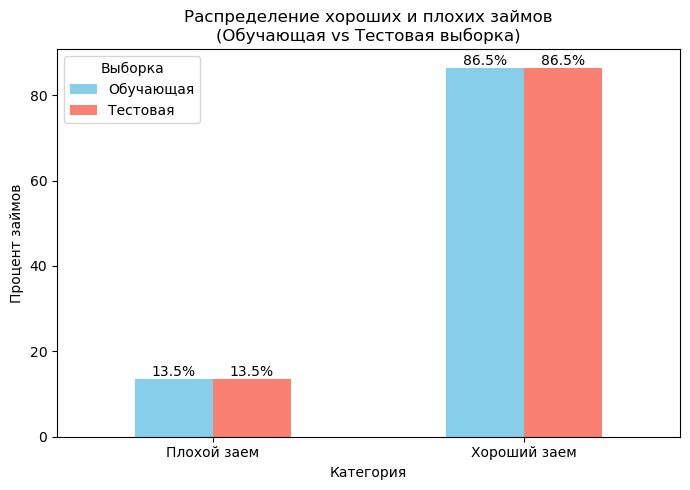

In [21]:
import matplotlib.pyplot as plt

# --- Функция для анализа распределения целевой переменной ---
def summarize_target(y, label=""):
    """
    Создаёт таблицу с количеством и долей хороших и плохих займов.
    
    Параметры:
        y (pd.Series): Целевая переменная (0 = хороший заем, 1 = плохой)
        label (str): Название выборки (например, 'Train', 'Test')
    
    Возвращает:
        DataFrame с распределением по категориям
    """
    # Подсчитываем количество каждого класса (0 и 1)
    counts = y.value_counts().rename_axis("Статус кредита").reset_index(name="Количество")
    
    # Преобразуем числовые метки в понятные категории
    counts["Категория"] = counts["Статус кредита"].map({
        0: "Хороший заем",
        1: "Плохой заем"
    })
    
    # Вычисляем процент от общего числа
    counts["Процент"] = (counts["Количество"] / counts["Количество"].sum() * 100).round(2)
    
    # Добавляем столбец с названием выборки (Train / Test)
    counts.insert(0, "Выборка", label)
    
    # Возвращаем только нужные столбцы в удобном порядке
    return counts[["Выборка", "Категория", "Статус кредита", "Количество", "Процент"]]


# Применяем функцию к обучающей и тестовой выборкам
train_summary = summarize_target(y_train, "Обучающая")
test_summary  = summarize_target(y_test,  "Тестовая")

# Объединяем результаты в одну таблицу
summary_table = pd.concat([train_summary, test_summary], ignore_index=True)

# Выводим таблицу
print("Распределение статусов займов в обучающей и тестовой выборках:\n")
display(summary_table)


# --- График: сравнение распределений ---
fig, ax = plt.subplots(figsize=(7, 5))

# Преобразуем таблицу в сводную для визуализации: строки — категории, столбцы — выборки
summary_plot = summary_table.pivot(index="Категория", columns="Выборка", values="Процент")

# Строим столбчатую диаграмму
summary_plot.plot(
    kind="bar",
    ax=ax,
    rot=0,                    # Без поворота подписей оси X
    color=["skyblue", "salmon"]  # Цвета: голубой (обуч.), светло-красный (тест)
)

# Настройка графика
ax.set_ylabel("Процент займов")
ax.set_title("Распределение хороших и плохих займов\n(Обучающая vs Тестовая выборка)")

# Добавляем проценты над столбцами
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height):  # Проверяем, что значение не NaN
        ax.annotate(f"{height:.1f}%", 
                    (p.get_x() + p.get_width()/2., height), 
                    ha='center', va='bottom')  # По центру столбца, снизу

# Убираем лишние отступы
plt.tight_layout()

# Отображаем график
plt.show()

# Следующая итерация это Feature Engineering

Но его нет :( 

In [12]:
df_final.to_csv('checkpoint_df.csv')

In [4]:
df_final = pd.read_csv('checkpoint_df.csv')
df_final.shape

(452134, 107)

# Построение ML-модели

In [5]:
df_sample = df_final.sample(frac=0.1, random_state=42)

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score, accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Топорная очистка от пропусков - ТАК НЕ ДЕЛАЙТЕ

In [9]:
# Разделим столбцы на числовые и категориальные
numeric_features = df_sample.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Затем удаляем 'target' из numeric_features
if 'target' in numeric_features:
    numeric_features.remove('target')
    
categorical_features = df_sample.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Числовые признаки ({len(numeric_features)}): {numeric_features[:5]}...")
print(f"Категориальные признаки ({len(categorical_features)}): {categorical_features[:5]}...")

Числовые признаки (84): ['Unnamed: 0', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate']...
Категориальные признаки (22): ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length']...


In [12]:
# 1. Заменяем пропуски в числовых признаках на 0
df_sample[numeric_features] = df_sample[numeric_features].fillna(0)

# 2. Заменяем пропуски в категориальных признаках на 'missing'
df_sample[categorical_features] = df_sample[categorical_features].fillna('missing')

In [14]:
# Проверим, остались ли пропуски после обработки
if df_sample.isnull().sum().sum() == 0:
    print("Пропусков нет — всё заполнено.")
else:
    print("Ещё остались пропуски!")
    print(df_final.isnull().sum()[df_final.isnull().sum() > 0])

Пропусков нет — всё заполнено.


In [16]:
target_col = 'target'  
y = df_sample[target_col]          # целевая переменная
X = df_sample.drop(columns=[target_col])  # все остальные признаки

# Разделяем на train и test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,           # 20% на тест
    random_state=42,
    stratify=y               
)

### 1. Создадим пайплайн препроцессинга

In [18]:
# Препроцессор: обрабатываем разные типы признаков по-разному
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),           # нормализуем числовые
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)  # кодируем категориальные
    ]
)

- drop='first' — избегаем мультиколлинеарности
- handle_unknown='ignore' — защита при предсказании

Что значит `handle_unknown`='ignore' — "защита при предсказании"?

Ситуация:

Мы обучили модель на данных, где категориальный признак home_ownership имеет значения: `RENT`, `OWN`, `MORTGAGE`

Но в тестовых или новых данных появляется значение, которого не было в обучении: `OTHER`

По умолчанию OneHotEncoder выдаст ошибку, потому что не знает, как его кодировать.

### 2. Сборка полного пайплайна

In [20]:
# Словарь моделей
models = {
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]) #,
    # "SVM": Pipeline([
    #     ('preprocessor', preprocessor),
    #     ('classifier', SVC(probability=True, random_state=42))
    # ])
}

### 3. Обучение и оценка моделей при помощи метрик качества

In [22]:
print("Столбцы в X_train:", X_train.shape[1])
print("Столбцы в X_test:", X_test.shape[1])
print("Совпадают:", list(X_train.columns) == list(X_test.columns))

Столбцы в X_train: 106
Столбцы в X_test: 106
Совпадают: True


In [24]:
results = {}

# Создаем прогресс-бар для итерации по моделям
for name, model in tqdm(models.items(), desc="Обучение моделей", unit="модель"):
    # Обучение с прогресс-баром
    print(f"\nОбучение {name}...")
    model.fit(X_train, y_train)
    
    # Предсказания
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Сохраняем метрики
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }
    
    print(f"{name} завершён")

# Выводим результаты
print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ МОДЕЛЕЙ:")
print("="*50)

for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")

Обучение моделей:   0%|                                                                                                                                                                                                                                      | 0/2 [00:00<?, ?модель/s]


Обучение Logistic Regression...


F:\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3, 10, 11, 13, 15, 16, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3, 10, 11, 13, 15, 16, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Обучение моделей:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 1/2 [00:05<00:05,  5.08s/модель]

Logistic Regression завершён

Обучение Random Forest...


F:\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3, 10, 11, 13, 15, 16, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3, 10, 11, 13, 15, 16, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Обучение моделей: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:02<00:00, 31.02s/модель]

Random Forest завершён

РЕЗУЛЬТАТЫ МОДЕЛЕЙ:

Logistic Regression:
  accuracy: 0.9884
  precision: 0.9913
  recall: 0.9231
  f1: 0.9560
  roc_auc: 0.9946

Random Forest:
  accuracy: 0.9633
  precision: 1.0000
  recall: 0.7312
  f1: 0.8447
  roc_auc: 0.9883


In [25]:
results_df = pd.DataFrame(results).T
print("Сравнение моделей:")
print(results_df.round(3))

Сравнение моделей:
                     accuracy  precision  recall     f1  roc_auc
Logistic Regression     0.988      0.991   0.923  0.956    0.995
Random Forest           0.963      1.000   0.731  0.845    0.988


In [26]:
# Словари для хранения предсказаний
y_pred_dict = {}
y_proba_dict = {}

# Прогресс-бар для получения предсказаний
for name, model in tqdm(models.items(), desc="Получение предсказаний", unit="модель"):
    y_pred_dict[name] = model.predict(X_test)
    y_proba_dict[name] = model.predict_proba(X_test)[:, 1]

Получение предсказаний:   0%|                                                                                                                                                                                                                                | 0/2 [00:00<?, ?модель/s]F:\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3, 10, 11, 13, 15, 16, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3, 10, 11, 13, 15, 16, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Получение предсказаний:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 1/

Построение ROC-кривых: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 181.80модель/s]


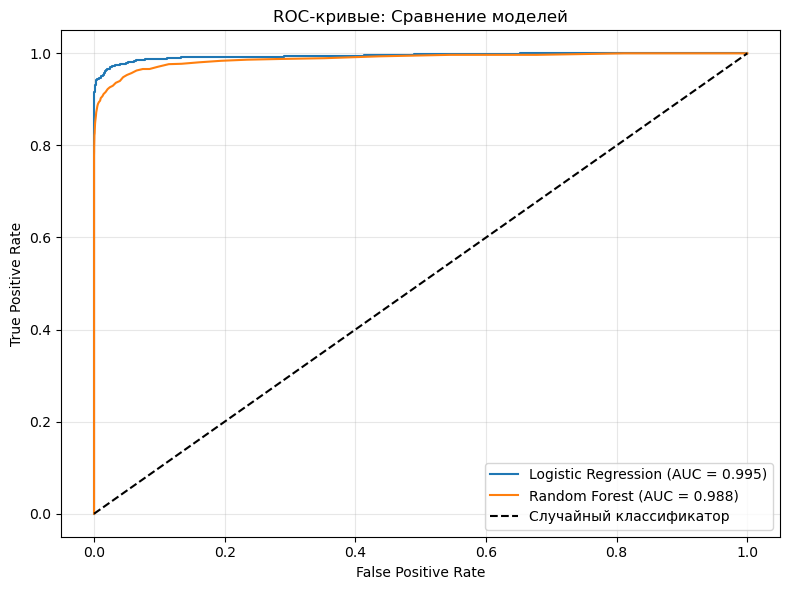

In [30]:
plt.figure(figsize=(8, 6))

# Прогресс-бар для построения ROC-кривых
model_names = list(y_proba_dict.keys())

for name in tqdm(model_names, desc="Построение ROC-кривых", unit="модель"):
    fpr, tpr, _ = roc_curve(y_test, y_proba_dict[name])
    auc = roc_auc_score(y_test, y_proba_dict[name])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Диагональ — случайный классификатор
plt.plot([0, 1], [0, 1], 'k--', label="Случайный классификатор")

# Оформление
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые: Сравнение моделей")
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4. Тюнинг гиперпараметров (GridSearchCV)

In [ ]:
# Общий пайплайн с placeholder-моделью
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())  # заглушка
])

# Сетка параметров: включает выбор модели!
param_grid = [
    {
        'classifier': [LogisticRegression(max_iter=1000)],
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2']
    },
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [5, 10, None]
    }
]

# Поиск лучшей модели и параметров
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Лучшая модель:", grid_search.best_estimator_['classifier'].__class__.__name__)
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший AUC:", grid_search.best_score_.round(4))

In [ ]:
import joblib

# Сохраняем лучшую модель
joblib.dump(grid_search.best_estimator_, 'credit_scoring_model.pkl')